# Case study
Given a user’s past reviews on Yelp (available from yelp-challenge dataset),

When the user writes a review for a business she hasn't reviewed before,

How likely will it be a Five-Star review?

- Load data
- Visualize the data
- Featurize the data
- Join tables to populate the features
- Model the data: Logistic regression
- Evaluate the model
- Make prediction with the model

# Load data

In [1]:
import pandas as pd

PATH = '/scratch/xun/docs/yelp_dataset_challenge_round10/'
biz_df = pd.read_csv(PATH + 'business.csv')
user_df = pd.read_csv(PATH + 'user.csv')
review_df = pd.read_csv(PATH + 'review.csv')

In [2]:
review_df = review_df.set_index('review_id')
user_df = user_df.set_index('user_id')
biz_df = biz_df.set_index('business_id')

# Visualize the data

## Example: Plot distribution of review star ratings

In [3]:
import seaborn as sns
%matplotlib inline

# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

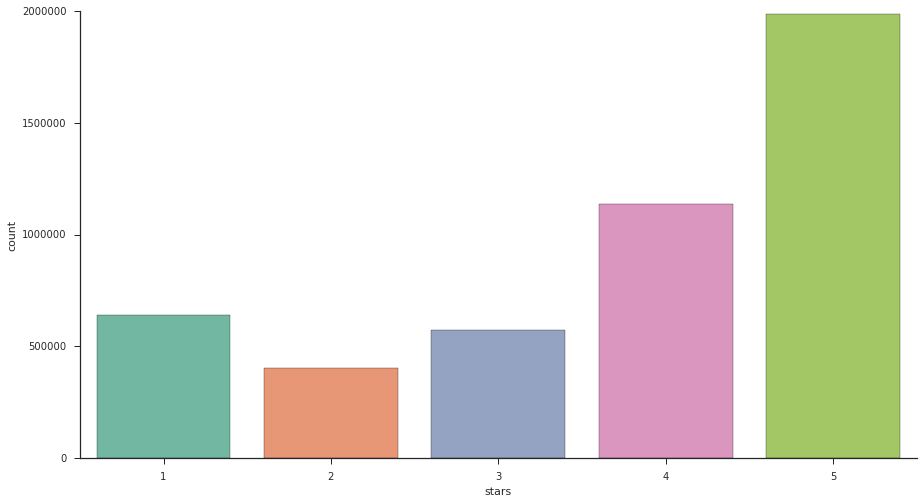

In [4]:
ax = sns.countplot(x='stars', data=review_df)
# Removing spines
sns.despine()

## Example: Plot review star ratings by year

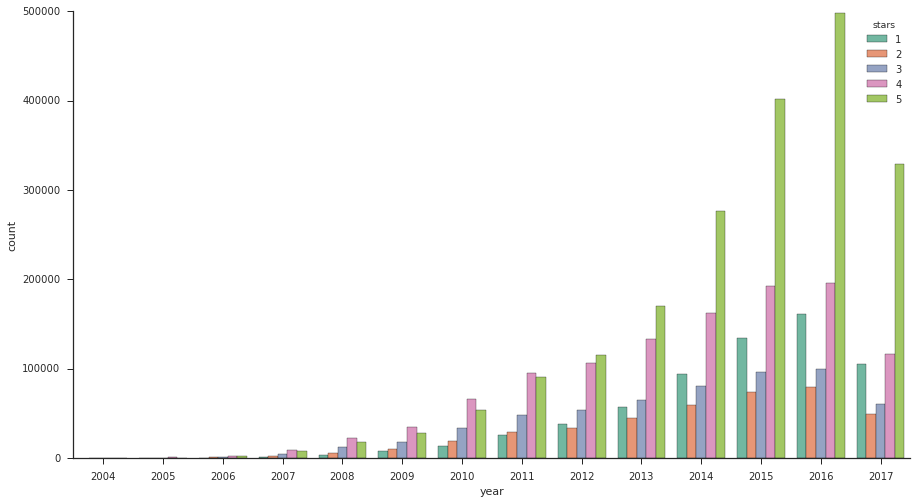

In [5]:
review_df['datetime'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['datetime'].dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
sns.despine()

# Featurize the data

- Convert date string to date delta
  - For example, business_age
- Convert strings to categorical features
  - For example, noise level: quiet, loud, very loud.
- Drop unused features
  - For example, business_name

In [6]:
def calculate_date_delta(df, from_column, to_column):
    datetime = pd.to_datetime(df[from_column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(from_column, axis=1, inplace=True)

In [7]:
def to_length(df, from_column, to_column):
    df[to_column] = df[from_column].apply(lambda x: len(x))
    df.drop(from_column, axis=1, inplace=True)

In [8]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [9]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [10]:
FILL_WITH = 0.0

In [11]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        #print 'categories for ', column, ' include ', df[column].cat.categories

In [12]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        #print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        #print 'becomes ', df[column].cat.categories

In [13]:
calculate_date_delta(df=review_df, from_column='date', to_column='date_delta')

In [14]:
to_length(df=review_df, from_column='text', to_column='text_len')

In [15]:
drop_columns(df=review_df, columns=['year', 'datetime'])

In [16]:
review_df.fillna(value=0.0, inplace=True)

In [17]:
calculate_date_delta(df=user_df, from_column='yelping_since', to_column='date_delta')

In [18]:
to_length(df=user_df, from_column='friends', to_column='friends_count')

In [19]:
to_length(df=user_df, from_column='elite', to_column='elite_count')

In [20]:
drop_columns(df=user_df, columns=['name'])

In [21]:
user_df.fillna(value=0.0, inplace=True)

In [22]:
drop_columns(
    df=biz_df,
    columns=[
        'postal_code',
        'name',
        'city',
        'address',
        'state',
        'categories',
        'longitude',
        'latitude',
        'neighborhood',
        'hours.Monday',
        'hours.Tuesday',
        'hours.Wednesday',
        'hours.Thursday',
        'hours.Friday',
        'hours.Saturday',
        'hours.Sunday',
    ]
)

In [23]:
# print out all the unique values, help clean up data to be float type
#for column in biz_df.columns:
    #print column, biz_df[column].unique()

In [24]:
to_cat_columns = [
    'attributes.Ambience.casual',
    'attributes.AgesAllowed',
    'attributes.Alcohol',
    'attributes.NoiseLevel',
    'attributes.RestaurantsAttire',
    'attributes.RestaurantsPriceRange2',
    'attributes.BYOBCorkage',
    'attributes.WiFi',
    'attributes.Smoking',
]

to_category(
    df=biz_df,
    columns=to_cat_columns,
)

In [25]:
biz_df.fillna(value=FILL_WITH, inplace=True)

In [26]:
category_rename_to_int(
    df=biz_df,
    columns=to_cat_columns,
)

# Join tables to populate the features

Join three tables (review, biz, user) to one (review-with-all-info).
Each join is a many-to-one join.

In [27]:
# The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.
review_join_user = review_df.join(user_df, on='user_id', lsuffix='_review', rsuffix='_user')

In [28]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id', rsuffix='_biz')

In [29]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

# Identify data X and target y
Data X: all features we gathered from business, user, and review tables.

Target y: what we'd like to predict: Whether the review is Five-star or not.

In [30]:
# target y is whether a review is five-star
y = review_join_user_join_biz.stars.apply(lambda x: x == 5)

# We've already dropped not informative features data X
X = review_join_user_join_biz
review_join_user_join_biz.drop('stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

# Split training set and testing set

In [31]:
from sklearn.cross_validation import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

/nail/home/xun/pg/ipython-notebook/venv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
#print 'features', features

training data shape (3552672, 109)
test data shape (1184225, 109)
converted label data shape (3552672,)


# Model the data: Logistic regression

Logistic regression estimates the probability of a binary response based on one or more features.

Here we estimate the probability of a review being five-star.

In [33]:
from sklearn import preprocessing

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
from sklearn.cross_validation import cross_val_score
import numpy as np

# Function used to print cross-validation scores
def training_score(est, X, y, cv):
    acc = cross_val_score(est, X, y, cv = cv, scoring='accuracy')
    roc = cross_val_score(est, X, y, cv = cv, scoring='roc_auc')
    print '5-fold Train CV | Accuracy:', round(np.mean(acc), 3),'+/-', \
    round(np.std(acc), 3),'| ROC AUC:', round(np.mean(roc), 3), '+/-', round(np.std(roc), 3)

In [35]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression()

In [36]:
from sklearn.cross_validation import StratifiedKFold

# cross-validation 
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True)

In [37]:
# print cross-validation scores
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=cv)

5-fold Train CV | Accuracy: 0.76 +/- 0.001 | ROC AUC: 0.836 +/- 0.001


# Evaluation via Confusion Matrix 

False positive (upper right).

False negative (bottom left)

In [38]:
# Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Run classifier
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[ 0.82491928  0.17508072]
 [ 0.33127357  0.66872643]]


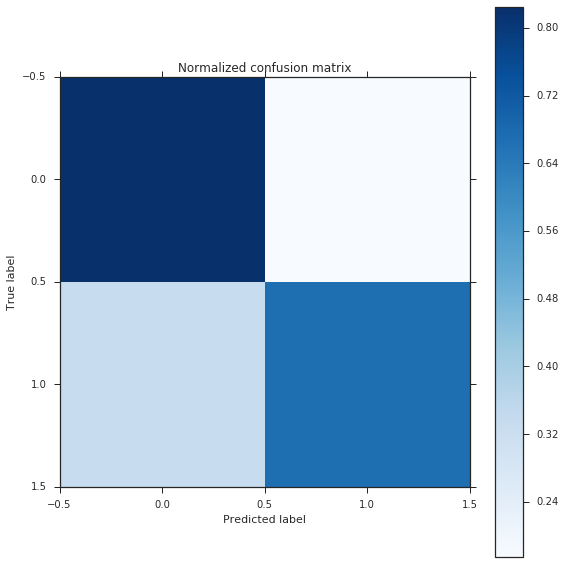

In [39]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

# Make prediction with the model

Randomly pick an anonymous user from the dataset.

Example: Predict whether the user will give a business a Five-star rating.

In [251]:
def predict_given_user_biz(user, biz, biz_name, review_df):
    a_user = user.copy()
    a_biz = biz.copy()
    # The review hasn't actually be written yet.
    # XXX(xun): We fake the feature using global mean/avg values to create a "general" review. 
    #   There are many other/better ways to fake the review to be more representative
    #   (e.g. draw from the real distribution, or avg of the user / the biz). 
    '''
    a_review = pd.DataFrame(
        {
            'funny': 0.0,#review_df['funny'].mean(),
            'user_id': a_user.index,
            'business_id': a_biz.index,
            'useful': 0.0,#review_df['useful'].mean(),
            'cool': 0.0,#review_df['cool'].mean(),
            'date_delta': review_df['date_delta'].mean(),
            'text_len': review_df['text_len'].mean(),
        }
    )
    '''
    a_review = pd.DataFrame(
        {
            'funny': 0.0,
            'user_id': a_user.index,
            'business_id': a_biz.index,
            'useful': 0.0,
            'cool': 0.0,
            'date_delta': 0,#review_df['date_delta'].mean(),
            'text_len': 0,#review_df['text_len'].mean(),
        }
    )

    a_review_join_user = a_review.join(a_user, on='user_id', lsuffix='_review', rsuffix='_user')
    a_X_test = a_review_join_user.join(a_biz, on='business_id', rsuffix='_biz')

    drop_columns(df=a_X_test, columns=['user_id', 'business_id'])
    a_X_test.fillna(value=FILL_WITH, inplace=True)
    
    a_X_test_scaled = scaler.transform(a_X_test)
    
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    
    print 'prediction for user ', a_user.index.values[0], ' on business ', biz_name, ' is ', a_y_pred[0]

In [238]:
def predict_given_user_biz2(user, biz, biz_name, review_df):
    a_user = user.copy()
    a_biz = biz.copy()
    # The review hasn't actually be written yet.
    # XXX(xun): We fake the feature using global mean/avg values to create a "general" review. 
    #   There are many other/better ways to fake the review to be more representative
    #   (e.g. draw from the real distribution, or avg of the user / the biz). 

    a_review = pd.DataFrame(
        {
            'funny': np.array([review_df['funny'].mean()] * a_biz.shape[0]),
            'user_id': np.array([a_user.index.values[0]] * a_biz.shape[0]),
            'business_id': a_biz.index.values,
            'useful': np.array([review_df['useful'].mean()] * a_biz.shape[0]),
            'cool': np.array([review_df['cool'].mean()] * a_biz.shape[0]),
            'date_delta': np.array([review_df['cool'].mean()] * a_biz.shape[0]), #review_df['date_delta'].mean(),
            'text_len': np.array([review_df['text_len'].mean()] * a_biz.shape[0]), #review_df['text_len'].mean(),
        }
    )
    '''
    a_review = pd.DataFrame(
        {
            'funny': np.array([0.0] * a_biz.shape[0]),
            'user_id': np.array([a_user.index.values[0]] * a_biz.shape[0]),
            'business_id': a_biz.index.values,
            'useful': np.array([0.0] * a_biz.shape[0]),
            'cool': np.array([0.0] * a_biz.shape[0]),
            'date_delta': np.array([0.0] * a_biz.shape[0]), #review_df['date_delta'].mean(),
            'text_len': np.array([0.0] * a_biz.shape[0]), #review_df['text_len'].mean(),
        }
    )
    '''
    a_review_join_user = a_review.join(a_user, on='user_id', lsuffix='_review', rsuffix='_user')
    a_X_test = a_review_join_user.join(a_biz, on='business_id', rsuffix='_biz')

    drop_columns(df=a_X_test, columns=['user_id', 'business_id'])
    a_X_test.fillna(value=FILL_WITH, inplace=True)
    
    a_X_test_scaled = scaler.transform(a_X_test)
    
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    
    print a_y_pred
    print a_y_pred.shape[0]
    print sum(a_y_pred)


In [142]:
user1 = user_df[user_df.index == 'Hj20fg3vyzKnJwnLn_rMqw']
#print user1.review_count
print user1.average_stars

user_id
Hj20fg3vyzKnJwnLn_rMqw    4.55
Name: average_stars, dtype: float64


In [125]:
user2 = user_df[user_df.index == 'kEtR1ZVL3Xr-tEX7lg16dQ']
#print user2.review_count
print user2.average_stars

user_id
kEtR1ZVL3Xr-tEX7lg16dQ    4.96
Name: average_stars, dtype: float64


In [234]:
#biz1 = biz_df[biz_df.index == 'u-SJ5QUwrNquL9VnXwl8cg']
biz1 = biz_df[biz_df.index == 'uUEMrhJiL1a1pCA_I1SU7Q']
#print biz1.review_count
print biz1.stars

business_id
uUEMrhJiL1a1pCA_I1SU7Q    5.0
Name: stars, dtype: float64


In [127]:
biz2 = biz_df[biz_df.index == 'MtUUc5w3HuDMcmL89RcG6Q']
#print biz2.review_count
print biz2.stars

business_id
MtUUc5w3HuDMcmL89RcG6Q    2.5
Name: stars, dtype: float64


# biz1: https://www.yelp.com/biz/postino-arcadia-phoenix

<img src="postino-arcadia-phoenix.png" alt="postino-arcadia-phoenix" width="800">

# biz2 https://www.yelp.com/biz/port-authority-of-allegheny-county-pittsburgh

<img src="port-authority-of-allegheny-county-pittsburgh.png" alt="port-authority-of-allegheny-county-pittsburgh" width="800">

In [252]:
predict_given_user_biz(user=user1, biz=biz1, biz_name="Postino Arcadia Phoenix", review_df=review_df)
predict_given_user_biz(user=user2, biz=biz1, biz_name="Postino Arcadia Phoenix", review_df=review_df)

predict_given_user_biz(user=user1, biz=biz1, biz_name="Port Authority of Allegheny County", review_df=review_df)
predict_given_user_biz(user=user2, biz=biz2, biz_name="Port Authority of Allegheny County", review_df=review_df)

prediction for user  Hj20fg3vyzKnJwnLn_rMqw  on business  Postino Arcadia Phoenix  is  True
prediction for user  kEtR1ZVL3Xr-tEX7lg16dQ  on business  Postino Arcadia Phoenix  is  True
prediction for user  Hj20fg3vyzKnJwnLn_rMqw  on business  Port Authority of Allegheny County  is  True
prediction for user  kEtR1ZVL3Xr-tEX7lg16dQ  on business  Port Authority of Allegheny County  is  True


In [241]:
filtered_biz = biz_df[biz_df.stars <4].head(n=10)
filtered_user = user_df[user_df.average_stars >= 4.9].head(n=10)

In [243]:
predict_given_user_biz2(user=user1, biz=filtered_biz, biz_name="Postino Arcadia Phoenix", review_df=review_df)

[False  True False False False  True  True  True  True  True]
10
6


In [207]:
np.array(filtered_biz.index.values)

array(['uUEMrhJiL1a1pCA_I1SU7Q', '2eJEUJIP54tex7T9YOcLSw',
       'kFtuYklkAIlmYw8RZAieGw', 'NqiQdFa93wzUJGo29NbTPQ',
       'igcy3ojJbgbpS8K70gvFQg', '5Ghe0btvM7tXqANnhNB5eg',
       'aj1C0D7hniEPpsTidbCQIg', 'g-HSA1m2vFPjKHYnqiL6qA',
       'fIWozPW-2wRknzsDqdgyjg', 'UlDvngOADDhshzMKvrMsQw'], dtype=object)

In [212]:
np.array([user2.index.values[0],] * 5)

array(['kEtR1ZVL3Xr-tEX7lg16dQ', 'kEtR1ZVL3Xr-tEX7lg16dQ',
       'kEtR1ZVL3Xr-tEX7lg16dQ', 'kEtR1ZVL3Xr-tEX7lg16dQ',
       'kEtR1ZVL3Xr-tEX7lg16dQ'], 
      dtype='|S22')

In [222]:
filtered_biz

10